## Import Necessary Python Packages/Libraries 

You will need to import the following packages in order to run this code

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import sklearn
import emcee
import corner
import seaborn as sns
import joblib
import tensorflow as tf
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

## Define Functions

In [2]:
def read_pdos(filename):
    f = open(filename)
    data = f.readlines()
    x = []
    for datum in data:
        inp = datum.split()
        inp = [ float(i) for i in inp ]
        x.append(inp)
    return np.asarray(x)

In [3]:
#Define function to calculate chi-square statistic
def chi_sq(a, b, err):
    chi_sq = []
    for i, el in enumerate(a):
        chi_sq.append((el - b[i])**2/err[i])
    return np.sum(np.array(chi_sq))

In [4]:
#Define function to calculate log-likelihood
def lnlike(theta, y, yerr):
    lim = q_values
    theta = np.expand_dims(theta, axis=0)  
    y_model = s_ml_model(theta).numpy().flatten()
    _tmp = ((y[:lim] - y_model[:lim])**2 / yerr[:lim]) / y[:lim]
    LnLike = -0.5 * np.sum(_tmp)
    return LnLike

In [5]:
#Define function to calculate the log-prior 
def lnprior(theta):
    JF1, JF2 = theta
    if 0 < JF1 < 1 and 0. < JF2 < 1:
        return 0.0
    else:
        return -np.inf

In [6]:
#Define function to calculate log-posterior
def lnprob(theta, y, yerr):

    lp = lnprior(theta)
    if not lp == 0:
        return -np.inf
    return lp + lnlike(theta, y, yerr)

In [7]:
#Define MCMC sampling function
def main(p0, nwalkers, niter, ndim, lnprob, data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100, progress=True)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

## Define Constants


In [8]:
q_values = 225 #Number of q values to be used in the sampling 
limits = [(0, 1), (0, 1)] #Define limits for parameters and prior distribution 
nwalkers = 25 # Number of walkers for MCMC sampling 
niter = 1000 # Number of iterations for MCMC sampling
initial = np.array([0.1, 0.1]) # Define uniform prior
ndim = 2 # Number of parameters for MCMC sampling 
p0 = [np.random.rand(ndim) for i in range(nwalkers)] # Define intial positions of walkers to be random

## Peform Scaling using Training Data Set

In [9]:
# Load Training Data
data = pd.read_pickle('SAXS_Data.pickle')

# Initialize lists to store extracted data
charge_number_list = []
kappa_list = []
scattering_list = []

for d in data:
    charge_number_list.append(d['charge_number'])
    kappa_list.append(d['kappa'])
    scattering_list.append(d['scattering'])

charge_number_data = np.array(charge_number_list).reshape(-1, 1)
kappa_data = np.array(kappa_list).reshape(-1, 1)
scattering_data = np.array(scattering_list)

# Extract features and labels
y = np.concatenate((charge_number_data, kappa_data), axis=1)
X = np.array([a[:q_values] for a in scattering_data])

# Scale features and labels using MinMaxScaler
min_max_scaler_sig = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler_sig.fit_transform(X)
min_max_scaler_labels = preprocessing.MinMaxScaler()
y_scaled = min_max_scaler_labels.fit_transform(y)

## Load the ANN Surrogate Model

We will be using the trained NN as the surrogate. Load it up here.

In [10]:
s_ml_model = tf.keras.models.load_model('2Param_Inverse_Model.h5')

## Load the experimental data

We load the experimental measurement and prepare it for MCMC Sampling.

In [11]:
# Load Experimental Data
expt = read_pdos('Experimental_Data.dat')
expt = pd.DataFrame(expt)
expt_scattering = expt.iloc[:, 1]
errors = expt.iloc[:, 2]
Xtra = copy.deepcopy(X)

# Scale data for MCMC Sampling using MinMaxScaler
expt_subset = expt.iloc[:225, 1].values.reshape(1, -1)
Xtra = np.concatenate((Xtra, expt_subset), axis=0)
min_max_scaler_sig = MinMaxScaler()
inputx = min_max_scaler_sig.fit_transform(Xtra)
err_expt = errors / np.max(errors)

sim = inputx[-1, :q_values]
err_expt = err_expt[:q_values]
data = (sim, err_expt)

## Perform MCMC Sampling

In [12]:
sampler_e, pos_e, prob_e, state_e = main(p0, nwalkers, 1000, ndim, lnprob, data)

Running burn-in...


100%|██████████| 100/100 [00:08<00:00, 11.92it/s]


Running production...


100%|██████████| 1000/1000 [01:20<00:00, 12.47it/s]


## MCMC Sampling Results

In [13]:
samples = sampler_e.flatchain
theta_max_e  = samples[np.argmax(sampler_e.flatlnprobability)] # Obtain maximum a posteriori estimates for two patameters
best_fit_model_e = s_ml_model(theta_max_e.reshape(1, -1)) # Calculate chi-square value for best fit parameters 

print('MAP Estimates:', theta_max_e)
print('Chi^2:', chi_sq(np.squeeze(best_fit_model_e)[:q_values], sim[:q_values], err_expt[:q_values]))

MAP Estimates: [0.24842672 0.01782731]
Chi^2: 4.475153222093958


## MCMC Corner Plot

Charge number: 24.906
Kappa: 6.837e-09


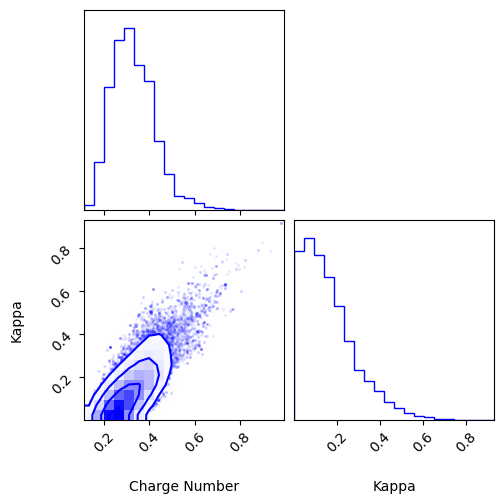

In [14]:
# Extract MCMC samples
samples = sampler_e.flatchain
theta_max_e = samples[np.argmax(sampler_e.flatlnprobability)]
theta_max_e = theta_max_e.reshape(1, -1)

# Inverse transform MAP using scaler
res_unscaled = min_max_scaler_labels.inverse_transform(theta_max_e).reshape(-1)
res_charge_number = res_unscaled[0]
res_kappa = 1 / res_unscaled[1]

# Print unscaled MAP values of parameters
print('Charge number: {:.3f}'.format(res_charge_number))
print('Kappa: {:.3e}'.format(res_kappa))

# Plotting corner plot with MCMC results
fig = corner.corner(samples, labels=['Charge Number', 'Kappa'], color='b', smooth=0.75)
plt.show()